<a href="https://colab.research.google.com/github/brendanfoo/predict_refugee_count/blob/main/Log_IDPs_NN_Models.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**SUMMARY OF NOTEBOOK (AFTER SCALING IDPS):**

Model | Specifications | Predict | Notes | Key Takeaways
------|----------------|---------|-------|---------------
NN | Log IDPs | Categorical | 3 bins, same code as Brendan's | Accuracy = 0.474
NN | Log IDPs | Categorical | 2 bins | Accuracy = 0.663
NN | Log IDPs | Continuous | N/A | MAPE = 34.6%

**SUMMARY OF NOTEBOOK (BEFORE SCALING IDPs):**

Model | Specifications | Predict | Notes | Key Takeaways
------|----------------|---------|-------|---------------
NN | Log IDPs | Categorical | Split (3) bins on range, same code as Brendan's | Accuracy = 0.516
NN | Log IDPs | Continuous | N/A | MAPE = 44.66%

# Imports

In [ ]:
# Imports
import pandas as pd
import numpy as np
import geopandas as gpd
import random
import altair as alt
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.utils import to_categorical

# Modelling
import tensorflow as tf
from tensorflow import keras
from keras import models
from keras import layers
from keras import metrics

# plots
import seaborn as sns
import matplotlib.pyplot as plt
tf.get_logger().setLevel('INFO')

import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

In [ ]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


# Neural Network

## Imports and Log Transformation of IDP Column

In [ ]:
fullmerge = pd.read_csv('/content/drive/MyDrive/210RefugeeMoves/datasets/FULLMERGE.csv').iloc[:, 1:]
fullmerge.drop(columns = ['Ended'])
fullmerge.head()

,ISO3,IDPs from Event,Economics,Governance,Social,Capacity,Ecosystem,Exposure,Food,Habitat,...,Began,Ended,MainCause,Severity,Duration,Magnitude,Population,Population Density (People per Sq. Km.),"Net international migrants, both sexes",Scaled_IDP
0,AFG,270,0.178628,0.172592,0.335777,0.757451,0.507907,0.480512,0.580916,0.537736,...,2013-04-23,2013-04-29,Torrential Rain,1.0,6.0,11.384192,"31,098,161",47.7,"-67,219",270
1,AFG,740,0.201495,0.193780,0.341216,0.732208,0.503280,0.480512,0.576083,0.539343,...,2014-04-20,2014-05-16,Torrential Rain,1.5,26.0,14.998823,"31,809,829",48.8,"-58,115",740
2,AFG,244,0.201495,0.193780,0.341216,0.732208,0.503280,0.480512,0.576083,0.539343,...,2014-04-20,2014-05-16,Torrential Rain,1.5,26.0,14.998823,"31,809,829",48.8,"-58,115",245
3,AFG,5775,0.201495,0.193780,0.341216,0.732208,0.503280,0.480512,0.576083,0.539343,...,2014-06-03,2014-06-10,Heavy Rain,1.5,7.0,13.047944,"31,809,829",48.8,"-58,115",5775
4,AFG,46380,0.210240,0.158260,0.354043,0.711203,0.509198,0.480512,0.615954,0.534952,...,2018-05-09,2018-05-22,Torrential Rain,1.5,13.0,15.095260,"34,907,481",53.5,"-21,703",46380


<Axes: ylabel='Density'>

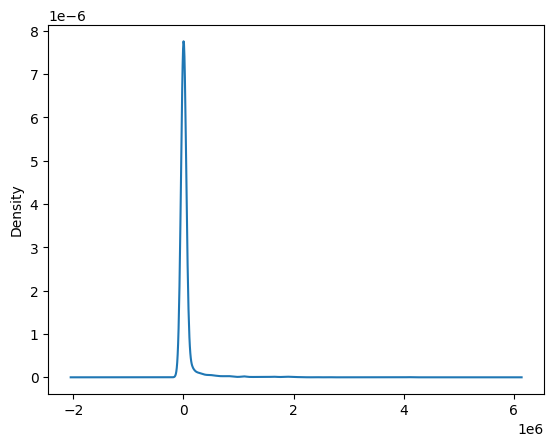

In [ ]:
nn_log_idps = fullmerge.dropna()

# plot distribution of 'IDPs from Event' column values
nn_log_idps['Scaled_IDP'].plot(kind = 'kde')

<ipython-input-6-c9c052668afd>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  nn_log_idps['log_idps'] = np.log(nn_log_idps['Scaled_IDP'])


<Axes: ylabel='Density'>

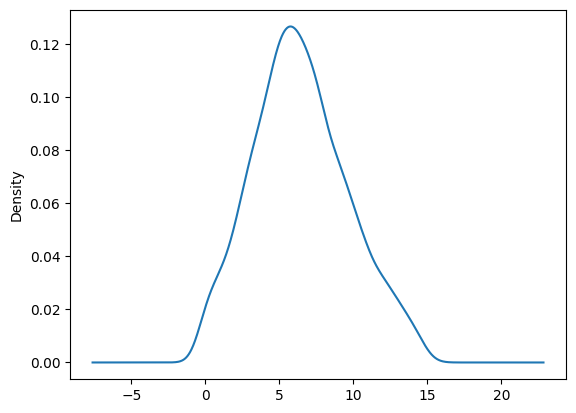

In [ ]:
nn_log_idps['log_idps'] = np.log(nn_log_idps['Scaled_IDP'])

# plot distribution of 'log_idps' column values
nn_log_idps['log_idps'].plot(kind = 'kde')

## Binning on Range w/ Logged IDPs - 3 Bins

In [ ]:
# Binning
cat_nn_log_idps = nn_log_idps.copy()
# cat_nn_log_idps['binnedIDPs'] = cat_nn_log_idps.groupby('ISO3')['log_idps'].apply(lambda x: pd.qcut(x, 3, duplicates = 'drop', labels = False).astype(str)) # BINS RELATIVE TO COUNTRY
cat_nn_log_idps['binnedIDPs'] = pd.qcut(cat_nn_log_idps['log_idps'], 3, duplicates = 'drop', labels = False).astype(str) # BINS AGNOSTIC OF COUNTRY
# cat_nn_log_idps = cat_nn_log_idps.drop(columns = ['IDPs from Event'])
cat_nn_log_idps = cat_nn_log_idps[~(cat_nn_log_idps['binnedIDPs'] == 'nan')]
def label(x):
  if x == '0':
    return 'low'
  if x == '1':
    return 'med'
  if x == '2':
    return 'high'
  return 'damn it'
cat_nn_log_idps['binnedIDPs'] = cat_nn_log_idps['binnedIDPs'].apply(label)
cat_nn_log_idps.head()

,ISO3,IDPs from Event,Economics,Governance,Social,Capacity,Ecosystem,Exposure,Food,Habitat,...,MainCause,Severity,Duration,Magnitude,Population,Population Density (People per Sq. Km.),"Net international migrants, both sexes",Scaled_IDP,log_idps,binnedIDPs
31,AGO,3920,0.139844,0.308112,0.18999,0.734707,0.54614,0.543063,0.571513,0.680376,...,Torrential Rain,1.5,14.0,12.448232,"27,292,819",21.9,"14,473",2125,7.661527,high
32,AGO,3920,0.139844,0.308112,0.18999,0.734707,0.54614,0.543063,0.571513,0.680376,...,Torrential Rain,1.5,14.0,12.279828,"27,292,819",21.9,"14,473",1796,7.493317,med
33,AGO,1192,0.139844,0.308112,0.18999,0.734707,0.54614,0.543063,0.571513,0.680376,...,Torrential Rain,1.5,14.0,12.448232,"27,292,819",21.9,"14,473",647,6.472346,med
34,AGO,1192,0.139844,0.308112,0.18999,0.734707,0.54614,0.543063,0.571513,0.680376,...,Torrential Rain,1.5,14.0,12.279828,"27,292,819",21.9,"14,473",546,6.302619,med
35,AGO,483,0.139844,0.308112,0.18999,0.734707,0.54614,0.543063,0.571513,0.680376,...,Torrential Rain,1.5,14.0,12.448232,"27,292,819",21.9,"14,473",262,5.568345,med


<Axes: >

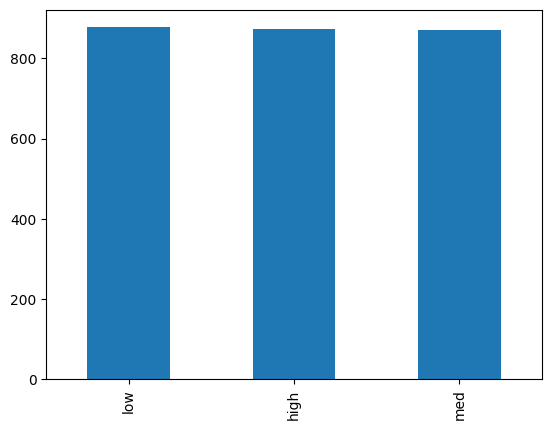

In [ ]:
cat_nn_log_idps['binnedIDPs'].value_counts().plot(kind='bar')

In [ ]:
cat_nn_log_idps.drop(columns = ['IDPs from Event', 'Scaled_IDP', 'log_idps'])

cat_nn_log_idps['Began'] = pd.to_datetime(cat_nn_log_idps['Began'])
month_ohe = pd.get_dummies(cat_nn_log_idps['Began'].dt.month, drop_first = True)

#iso_ohe = pd.get_dummies(cat_nn_log_idps['ISO3'], drop_first = True)

In [ ]:
cat_nn_log_idps = cat_nn_log_idps.drop(columns = ['ISO3', 'Began', 'Ended'])
cat_nn_log_idps = cat_nn_log_idps.join(month_ohe)
#cat_nn_log_idps = cat_nn_log_idps.join(iso_ohe)

cat_nn_log_idps['MainCause'] = cat_nn_log_idps['MainCause'].str.lower()

In [ ]:
cat_nn_log_idps['Storms'] = np.zeros(cat_nn_log_idps.shape[0])
cat_nn_log_idps['DamBreak'] = np.zeros(cat_nn_log_idps.shape[0])
cat_nn_log_idps['Rain'] = np.zeros(cat_nn_log_idps.shape[0])
cat_nn_log_idps['Melting'] = np.zeros(cat_nn_log_idps.shape[0])
cat_nn_log_idps['TidesTsunami'] = np.zeros(cat_nn_log_idps.shape[0])

In [ ]:
for index, row in cat_nn_log_idps.iterrows():
  maincause = row['MainCause']
  if ('tropical' in maincause) or ('storm' in maincause) or ('monsoon' in maincause) or ('cyclone' in maincause) or ('typhoon' in maincause):
    cat_nn_log_idps.loc[index, 'Storms'] = 1
  if ('dam' in maincause):
    cat_nn_log_idps.loc[index, 'DamBreak'] = 1
  if ('rain' in maincause):
    cat_nn_log_idps.loc[index, 'Rain'] = 1
  if ('snow' in maincause) or ('ice' in maincause) or ('glacier' in maincause) or ('jökulhlaup' in maincause):
    cat_nn_log_idps.loc[index, 'Melting'] = 1
  if ('tide' in maincause) or ('tsunami' in maincause):
    cat_nn_log_idps.loc[index, 'TidesTsunami'] = 1

In [ ]:
cat_nn_log_idps = cat_nn_log_idps.drop(columns = ['MainCause'])

In [ ]:
for col in cat_nn_log_idps.columns:
  print(col, end=' | ')

IDPs from Event | Economics | Governance | Social | Capacity | Ecosystem | Exposure | Food | Habitat | Health | Infrastructure | Sensitivity | Area | Severity | Duration | Magnitude | Population | Population Density (People per Sq. Km.) | Net international migrants, both sexes | Scaled_IDP | log_idps | binnedIDPs | 2 | 3 | 4 | 5 | 6 | 7 | 8 | 9 | 10 | 11 | 12 | Storms | DamBreak | Rain | Melting | TidesTsunami | 

In [ ]:
cat_nn_log_idps = cat_nn_log_idps.replace(',','', regex=True)
cat_nn_log_idps = cat_nn_log_idps.replace('--','0', regex=True)
cat_nn_log_idps.shape

(2622, 38)

In [ ]:
cat_nn_log_idps = cat_nn_log_idps.dropna()
cat_nn_log_idps.shape

(2622, 38)

In [ ]:
target = cat_nn_log_idps[['binnedIDPs']]
cat_nn_log_idps = cat_nn_log_idps.drop(columns = ['binnedIDPs'])
cat_nn_log_idps['binnedIDPs'] = target
cat_nn_log_idps = cat_nn_log_idps.drop(columns = ['IDPs from Event', 'Scaled_IDP', 'Area', 'Severity', 'Duration'])
cat_nn_log_idps.head()

,Economics,Governance,Social,Capacity,Ecosystem,Exposure,Food,Habitat,Health,Infrastructure,...,9,10,11,12,Storms,DamBreak,Rain,Melting,TidesTsunami,binnedIDPs
31,0.139844,0.308112,0.18999,0.734707,0.54614,0.543063,0.571513,0.680376,0.583568,0.298719,...,0,0,0,0,0.0,0.0,1.0,0.0,0.0,high
32,0.139844,0.308112,0.18999,0.734707,0.54614,0.543063,0.571513,0.680376,0.583568,0.298719,...,0,0,0,0,0.0,0.0,1.0,0.0,0.0,med
33,0.139844,0.308112,0.18999,0.734707,0.54614,0.543063,0.571513,0.680376,0.583568,0.298719,...,0,0,0,0,0.0,0.0,1.0,0.0,0.0,med
34,0.139844,0.308112,0.18999,0.734707,0.54614,0.543063,0.571513,0.680376,0.583568,0.298719,...,0,0,0,0,0.0,0.0,1.0,0.0,0.0,med
35,0.139844,0.308112,0.18999,0.734707,0.54614,0.543063,0.571513,0.680376,0.583568,0.298719,...,0,0,0,0,0.0,0.0,1.0,0.0,0.0,med


In [ ]:
cat_nn_log_idps = cat_nn_log_idps.drop(columns = [2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12])
cat_nn_log_idps = cat_nn_log_idps.drop(columns = ['Storms', 'DamBreak', 'Rain', 'Melting', 'TidesTsunami', 'log_idps'])
cat_nn_log_idps.head()

,Economics,Governance,Social,Capacity,Ecosystem,Exposure,Food,Habitat,Health,Infrastructure,Sensitivity,Magnitude,Population,Population Density (People per Sq. Km.),"Net international migrants, both sexes",binnedIDPs
31,0.139844,0.308112,0.18999,0.734707,0.54614,0.543063,0.571513,0.680376,0.583568,0.298719,0.273778,12.448232,27292819,21.9,14473,high
32,0.139844,0.308112,0.18999,0.734707,0.54614,0.543063,0.571513,0.680376,0.583568,0.298719,0.273778,12.279828,27292819,21.9,14473,med
33,0.139844,0.308112,0.18999,0.734707,0.54614,0.543063,0.571513,0.680376,0.583568,0.298719,0.273778,12.448232,27292819,21.9,14473,med
34,0.139844,0.308112,0.18999,0.734707,0.54614,0.543063,0.571513,0.680376,0.583568,0.298719,0.273778,12.279828,27292819,21.9,14473,med
35,0.139844,0.308112,0.18999,0.734707,0.54614,0.543063,0.571513,0.680376,0.583568,0.298719,0.273778,12.448232,27292819,21.9,14473,med


### Modeling: Predict Categorical (3 Bins)


In [ ]:
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.utils import to_categorical

X = cat_nn_log_idps.iloc[:, :-1] #features
IDPbins = cat_nn_log_idps.iloc[:, -1] #IDP bins (low, med, high)

# Encode labels into numerical values
le = LabelEncoder()
Y = le.fit_transform(IDPbins)

# Split the data into training and testing sets
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)
Y_train = tf.keras.utils.to_categorical(Y_train, 3)
Y_test = tf.keras.utils.to_categorical(Y_test, 3)

In [ ]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Build the neural network model
tf.keras.backend.clear_session()
np.random.seed(0)
tf.random.set_seed(0)

model = keras.Sequential()
model.add(keras.layers.Dense(128, input_dim=X_train.shape[1], activation='relu'))
model.add(keras.layers.Dropout(0.4))
model.add(keras.layers.Dense(64, activation='relu'))
model.add(keras.layers.Dropout(0.4))
model.add(keras.layers.Dense(32, activation='relu'))
model.add(keras.layers.Dropout(0.4))
model.add(keras.layers.Dense(3, activation='softmax'))  # Output layer with 3 classes

# Compile the model
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])


history = model.fit(X_train_scaled, Y_train, epochs=10, batch_size=10, validation_data=(X_test_scaled, Y_test))

# Evaluate the model on the test set
loss, accuracy = model.evaluate(X_test_scaled, Y_test)
print(f'Test Loss: {loss}, Test Accuracy: {accuracy}')

Epoch 1/10
210/210 [==============================] - 4s 9ms/step - loss: 1.1027 - accuracy: 0.3934 - val_loss: 1.0447 - val_accuracy: 0.4629
Epoch 2/10
210/210 [==============================] - 1s 3ms/step - loss: 1.0577 - accuracy: 0.4368 - val_loss: 1.0443 - val_accuracy: 0.4419
Epoch 3/10
210/210 [==============================] - 1s 2ms/step - loss: 1.0442 - accuracy: 0.4564 - val_loss: 1.0262 - val_accuracy: 0.4552
Epoch 4/10
210/210 [==============================] - 1s 3ms/step - loss: 1.0441 - accuracy: 0.4411 - val_loss: 1.0262 - val_accuracy: 0.4476
Epoch 5/10
210/210 [==============================] - 1s 3ms/step - loss: 1.0371 - accuracy: 0.4654 - val_loss: 1.0138 - val_accuracy: 0.4610
Epoch 6/10
210/210 [==============================] - 1s 4ms/step - loss: 1.0234 - accuracy: 0.4711 - val_loss: 1.0161 - val_accuracy: 0.4590
Epoch 7/10
210/210 [==============================] - 1s 4ms/step - loss: 1.0156 - accuracy: 0.4859 - val_loss: 1.0120 - val_accuracy: 0.4705
Epoch 

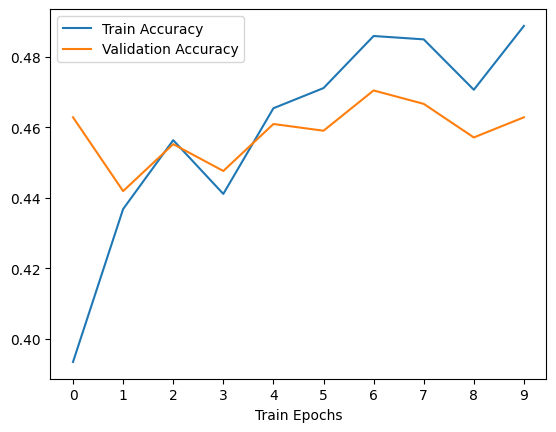

In [ ]:
train_accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
plt.plot(train_accuracy, label='Train Accuracy')
plt.plot(val_accuracy, label='Validation Accuracy')
plt.xticks(range(10))
plt.xlabel('Train Epochs')
plt.legend()
plt.show()

In [ ]:
predictions = model.predict(X_test_scaled)
predicted_labels = np.argmax(predictions, axis=1)
predictions = le.inverse_transform(predicted_labels.reshape(-1, 1))

17/17 [==============================] - 0s 2ms/step


/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:155: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [ ]:
numerical_Y = np.argmax(Y_test, axis=1)
test_labels = le.inverse_transform(numerical_Y.reshape(-1, 1))

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:155: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


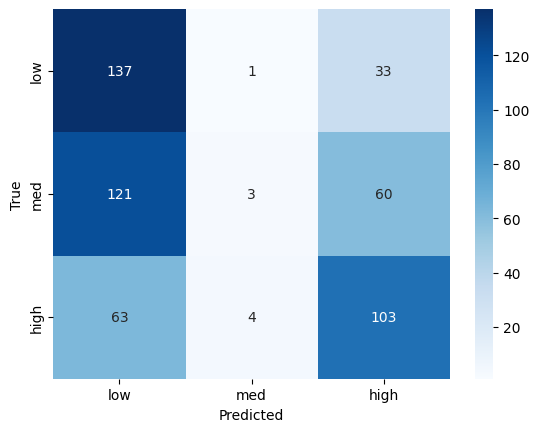

In [ ]:
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, ConfusionMatrixDisplay, classification_report
import seaborn

conf_mat = confusion_matrix(test_labels, predictions, labels=["low", "med", "high"])

seaborn.heatmap(conf_mat, xticklabels=["low", "med", "high"], yticklabels=["low", "med", "high"], annot=True, fmt="d", cmap="Blues")
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

In [ ]:
accuracy = accuracy_score(test_labels, predictions)
classification_rep = classification_report(test_labels, predictions, target_names=le.classes_)
print(accuracy, classification_rep)

0.46285714285714286               precision    recall  f1-score   support

        high       0.53      0.61      0.56       170
         low       0.43      0.80      0.56       171
         med       0.38      0.02      0.03       184

    accuracy                           0.46       525
   macro avg       0.44      0.47      0.38       525
weighted avg       0.44      0.46      0.37       525



In [ ]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, classification_report

# Create a decision tree classifier
model = DecisionTreeClassifier(random_state=42)

# Train the model
model.fit(X_train_scaled, Y_train)

# Make predictions on the test set
predictions = model.predict(X_test_scaled)

# Evaluate the model
accuracy = accuracy_score(Y_test, predictions)
print(f'Accuracy: {accuracy:.2f}')

# Display classification report
print('\nClassification Report:')
print(classification_report(Y_test, predictions))

Accuracy: 0.35

Classification Report:
              precision    recall  f1-score   support

           0       0.55      0.36      0.44       170
           1       0.51      0.45      0.48       171
           2       0.40      0.24      0.30       184

   micro avg       0.49      0.35      0.41       525
   macro avg       0.49      0.35      0.41       525
weighted avg       0.48      0.35      0.40       525
 samples avg       0.35      0.35      0.35       525



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


## Binning on Range w/ Logged IDPs - 2 Bins

In [ ]:
# Binning
cat_nn_log_idps = nn_log_idps.copy()
# cat_nn_log_idps['binnedIDPs'] = cat_nn_log_idps.groupby('ISO3')['log_idps'].apply(lambda x: pd.qcut(x, 3, duplicates = 'drop', labels = False).astype(str)) # BINS RELATIVE TO COUNTRY
cat_nn_log_idps['binnedIDPs'] = pd.qcut(cat_nn_log_idps['log_idps'], 2, duplicates = 'drop', labels = False).astype(str) # BINS AGNOSTIC OF COUNTRY
# cat_nn_log_idps = cat_nn_log_idps.drop(columns = ['IDPs from Event'])
cat_nn_log_idps = cat_nn_log_idps[~(cat_nn_log_idps['binnedIDPs'] == 'nan')]
def label(x):
  if x == '0':
    return 'low'
  if x == '1':
    return 'high'
  return 'damn it'
cat_nn_log_idps['binnedIDPs'] = cat_nn_log_idps['binnedIDPs'].apply(label)
cat_nn_log_idps.head()

,ISO3,IDPs from Event,Economics,Governance,Social,Capacity,Ecosystem,Exposure,Food,Habitat,...,MainCause,Severity,Duration,Magnitude,Population,Population Density (People per Sq. Km.),"Net international migrants, both sexes",Scaled_IDP,log_idps,binnedIDPs
31,AGO,3920,0.139844,0.308112,0.18999,0.734707,0.54614,0.543063,0.571513,0.680376,...,Torrential Rain,1.5,14.0,12.448232,"27,292,819",21.9,"14,473",2125,7.661527,high
32,AGO,3920,0.139844,0.308112,0.18999,0.734707,0.54614,0.543063,0.571513,0.680376,...,Torrential Rain,1.5,14.0,12.279828,"27,292,819",21.9,"14,473",1796,7.493317,high
33,AGO,1192,0.139844,0.308112,0.18999,0.734707,0.54614,0.543063,0.571513,0.680376,...,Torrential Rain,1.5,14.0,12.448232,"27,292,819",21.9,"14,473",647,6.472346,high
34,AGO,1192,0.139844,0.308112,0.18999,0.734707,0.54614,0.543063,0.571513,0.680376,...,Torrential Rain,1.5,14.0,12.279828,"27,292,819",21.9,"14,473",546,6.302619,high
35,AGO,483,0.139844,0.308112,0.18999,0.734707,0.54614,0.543063,0.571513,0.680376,...,Torrential Rain,1.5,14.0,12.448232,"27,292,819",21.9,"14,473",262,5.568345,low


<Axes: >

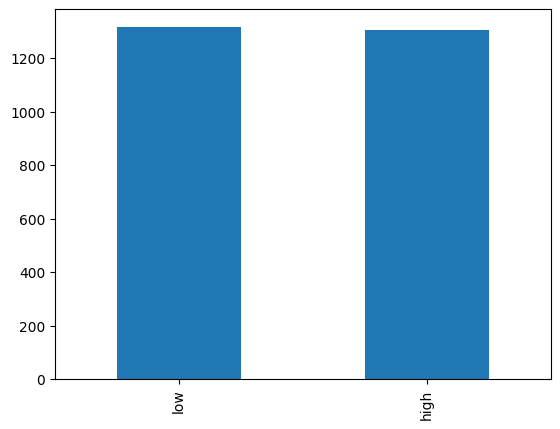

In [ ]:
cat_nn_log_idps['binnedIDPs'].value_counts().plot(kind='bar')

In [ ]:
cat_nn_log_idps.drop(columns = ['IDPs from Event', 'Scaled_IDP', 'log_idps'])

cat_nn_log_idps['Began'] = pd.to_datetime(cat_nn_log_idps['Began'])
month_ohe = pd.get_dummies(cat_nn_log_idps['Began'].dt.month, drop_first = True)

#iso_ohe = pd.get_dummies(cat_nn_log_idps['ISO3'], drop_first = True)

In [ ]:
cat_nn_log_idps = cat_nn_log_idps.drop(columns = ['ISO3', 'Began', 'Ended'])
cat_nn_log_idps = cat_nn_log_idps.join(month_ohe)
#cat_nn_log_idps = cat_nn_log_idps.join(iso_ohe)

cat_nn_log_idps['MainCause'] = cat_nn_log_idps['MainCause'].str.lower()

In [ ]:
cat_nn_log_idps['Storms'] = np.zeros(cat_nn_log_idps.shape[0])
cat_nn_log_idps['DamBreak'] = np.zeros(cat_nn_log_idps.shape[0])
cat_nn_log_idps['Rain'] = np.zeros(cat_nn_log_idps.shape[0])
cat_nn_log_idps['Melting'] = np.zeros(cat_nn_log_idps.shape[0])
cat_nn_log_idps['TidesTsunami'] = np.zeros(cat_nn_log_idps.shape[0])

In [ ]:
for index, row in cat_nn_log_idps.iterrows():
  maincause = row['MainCause']
  if ('tropical' in maincause) or ('storm' in maincause) or ('monsoon' in maincause) or ('cyclone' in maincause) or ('typhoon' in maincause):
    cat_nn_log_idps.loc[index, 'Storms'] = 1
  if ('dam' in maincause):
    cat_nn_log_idps.loc[index, 'DamBreak'] = 1
  if ('rain' in maincause):
    cat_nn_log_idps.loc[index, 'Rain'] = 1
  if ('snow' in maincause) or ('ice' in maincause) or ('glacier' in maincause) or ('jökulhlaup' in maincause):
    cat_nn_log_idps.loc[index, 'Melting'] = 1
  if ('tide' in maincause) or ('tsunami' in maincause):
    cat_nn_log_idps.loc[index, 'TidesTsunami'] = 1

In [ ]:
cat_nn_log_idps = cat_nn_log_idps.drop(columns = ['MainCause'])

In [ ]:
for col in cat_nn_log_idps.columns:
  print(col, end=' | ')

IDPs from Event | Economics | Governance | Social | Capacity | Ecosystem | Exposure | Food | Habitat | Health | Infrastructure | Sensitivity | Area | Severity | Duration | Magnitude | Population | Population Density (People per Sq. Km.) | Net international migrants, both sexes | Scaled_IDP | log_idps | binnedIDPs | 2 | 3 | 4 | 5 | 6 | 7 | 8 | 9 | 10 | 11 | 12 | Storms | DamBreak | Rain | Melting | TidesTsunami | 

In [ ]:
cat_nn_log_idps = cat_nn_log_idps.replace(',','', regex=True)
cat_nn_log_idps = cat_nn_log_idps.replace('--','0', regex=True)
cat_nn_log_idps.shape

(2622, 38)

In [ ]:
cat_nn_log_idps = cat_nn_log_idps.dropna()
cat_nn_log_idps.shape

(2622, 38)

In [ ]:
target = cat_nn_log_idps[['binnedIDPs']]
cat_nn_log_idps = cat_nn_log_idps.drop(columns = ['binnedIDPs'])
cat_nn_log_idps['binnedIDPs'] = target
cat_nn_log_idps = cat_nn_log_idps.drop(columns = ['IDPs from Event', 'Scaled_IDP', 'Area', 'Severity', 'Duration'])
cat_nn_log_idps.head()

,Economics,Governance,Social,Capacity,Ecosystem,Exposure,Food,Habitat,Health,Infrastructure,...,9,10,11,12,Storms,DamBreak,Rain,Melting,TidesTsunami,binnedIDPs
31,0.139844,0.308112,0.18999,0.734707,0.54614,0.543063,0.571513,0.680376,0.583568,0.298719,...,0,0,0,0,0.0,0.0,1.0,0.0,0.0,high
32,0.139844,0.308112,0.18999,0.734707,0.54614,0.543063,0.571513,0.680376,0.583568,0.298719,...,0,0,0,0,0.0,0.0,1.0,0.0,0.0,high
33,0.139844,0.308112,0.18999,0.734707,0.54614,0.543063,0.571513,0.680376,0.583568,0.298719,...,0,0,0,0,0.0,0.0,1.0,0.0,0.0,high
34,0.139844,0.308112,0.18999,0.734707,0.54614,0.543063,0.571513,0.680376,0.583568,0.298719,...,0,0,0,0,0.0,0.0,1.0,0.0,0.0,high
35,0.139844,0.308112,0.18999,0.734707,0.54614,0.543063,0.571513,0.680376,0.583568,0.298719,...,0,0,0,0,0.0,0.0,1.0,0.0,0.0,low


In [ ]:
cat_nn_log_idps = cat_nn_log_idps.drop(columns = [2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12])
cat_nn_log_idps = cat_nn_log_idps.drop(columns = ['Storms', 'DamBreak', 'Rain', 'Melting', 'TidesTsunami', 'log_idps'])
cat_nn_log_idps.head()

,Economics,Governance,Social,Capacity,Ecosystem,Exposure,Food,Habitat,Health,Infrastructure,Sensitivity,Magnitude,Population,Population Density (People per Sq. Km.),"Net international migrants, both sexes",binnedIDPs
31,0.139844,0.308112,0.18999,0.734707,0.54614,0.543063,0.571513,0.680376,0.583568,0.298719,0.273778,12.448232,27292819,21.9,14473,high
32,0.139844,0.308112,0.18999,0.734707,0.54614,0.543063,0.571513,0.680376,0.583568,0.298719,0.273778,12.279828,27292819,21.9,14473,high
33,0.139844,0.308112,0.18999,0.734707,0.54614,0.543063,0.571513,0.680376,0.583568,0.298719,0.273778,12.448232,27292819,21.9,14473,high
34,0.139844,0.308112,0.18999,0.734707,0.54614,0.543063,0.571513,0.680376,0.583568,0.298719,0.273778,12.279828,27292819,21.9,14473,high
35,0.139844,0.308112,0.18999,0.734707,0.54614,0.543063,0.571513,0.680376,0.583568,0.298719,0.273778,12.448232,27292819,21.9,14473,low


### Modeling: Predict Categorical (2 Bins)


In [ ]:
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.utils import to_categorical

X = cat_nn_log_idps.iloc[:, :-1] #features
IDPbins = cat_nn_log_idps.iloc[:, -1] #IDP bins (low, high)

# Encode labels into numerical values
le = LabelEncoder()
Y = le.fit_transform(IDPbins)

# Split the data into training and testing sets
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)
Y_train = tf.keras.utils.to_categorical(Y_train, 2)
Y_test = tf.keras.utils.to_categorical(Y_test, 2)

In [ ]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Build the neural network model
tf.keras.backend.clear_session()
np.random.seed(0)
tf.random.set_seed(0)

model = keras.Sequential()
model.add(keras.layers.Dense(128, input_dim=X_train.shape[1], activation='relu'))
model.add(keras.layers.Dropout(0.4))
model.add(keras.layers.Dense(64, activation='relu'))
model.add(keras.layers.Dropout(0.4))
model.add(keras.layers.Dense(32, activation='relu'))
model.add(keras.layers.Dropout(0.4))
model.add(keras.layers.Dense(2, activation='softmax'))  # Output layer with 2 classes

# Compile the model
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

history = model.fit(X_train_scaled, Y_train, epochs=10, batch_size=10, validation_data=(X_test_scaled, Y_test))

# Evaluate the model on the test set
loss, accuracy = model.evaluate(X_test_scaled, Y_test)
print(f'Test Loss: {loss}, Test Accuracy: {accuracy}')

Epoch 1/10
210/210 [==============================] - 2s 3ms/step - loss: 0.6814 - accuracy: 0.5880 - val_loss: 0.6438 - val_accuracy: 0.6419
Epoch 2/10
210/210 [==============================] - 1s 3ms/step - loss: 0.6614 - accuracy: 0.6109 - val_loss: 0.6469 - val_accuracy: 0.6514
Epoch 3/10
210/210 [==============================] - 1s 3ms/step - loss: 0.6596 - accuracy: 0.6094 - val_loss: 0.6384 - val_accuracy: 0.6610
Epoch 4/10
210/210 [==============================] - 1s 3ms/step - loss: 0.6544 - accuracy: 0.6280 - val_loss: 0.6353 - val_accuracy: 0.6571
Epoch 5/10
210/210 [==============================] - 1s 2ms/step - loss: 0.6448 - accuracy: 0.6466 - val_loss: 0.6313 - val_accuracy: 0.6648
Epoch 6/10
210/210 [==============================] - 1s 3ms/step - loss: 0.6429 - accuracy: 0.6361 - val_loss: 0.6326 - val_accuracy: 0.6495
Epoch 7/10
210/210 [==============================] - 1s 3ms/step - loss: 0.6389 - accuracy: 0.6619 - val_loss: 0.6305 - val_accuracy: 0.6629
Epoch 

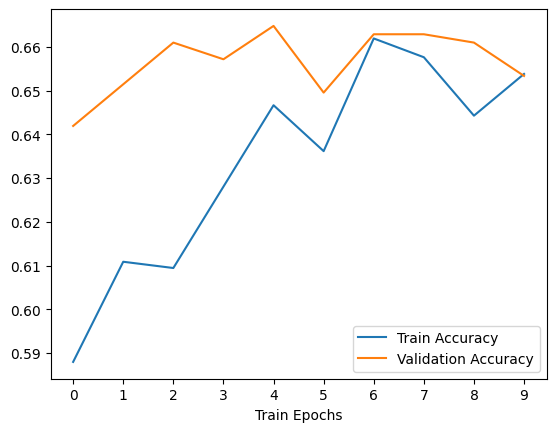

In [ ]:
train_accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
plt.plot(train_accuracy, label='Train Accuracy')
plt.plot(val_accuracy, label='Validation Accuracy')
plt.xticks(range(10))
plt.xlabel('Train Epochs')
plt.legend()
plt.show()

In [ ]:
predictions = model.predict(X_test_scaled)
predicted_labels = np.argmax(predictions, axis=1)
predictions = le.inverse_transform(predicted_labels.reshape(-1, 1))

17/17 [==============================] - 0s 2ms/step


/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:155: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [ ]:
numerical_Y = np.argmax(Y_test, axis=1)
test_labels = le.inverse_transform(numerical_Y.reshape(-1, 1))

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:155: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


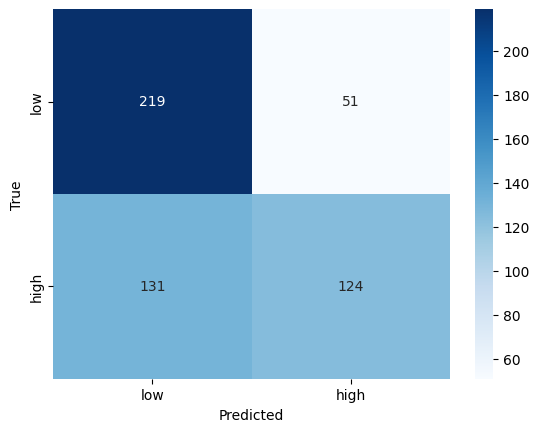

In [ ]:
from sklearn.metrics import confusion_matrix, f1_score, precision_score, recall_score
import seaborn

conf_mat = confusion_matrix(test_labels, predictions, labels=["low", "high"])

seaborn.heatmap(conf_mat, xticklabels=["low", "high"], yticklabels=["low", "high"], annot=True, fmt="d", cmap="Blues")
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

In [ ]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, classification_report

# Create a decision tree classifier
model = DecisionTreeClassifier(random_state=42)

# Train the model
model.fit(X_train_scaled, Y_train)

# Make predictions on the test set
predictions = model.predict(X_test_scaled)

# Evaluate the model
accuracy = accuracy_score(Y_test, predictions)
print(f'Accuracy: {accuracy:.2f}')

# Display classification report
print('\nClassification Report:')
print(classification_report(Y_test, predictions))

Accuracy: 0.61

Classification Report:
              precision    recall  f1-score   support

           0       0.67      0.56      0.61       255
           1       0.68      0.67      0.67       270

   micro avg       0.68      0.61      0.64       525
   macro avg       0.67      0.61      0.64       525
weighted avg       0.67      0.61      0.64       525
 samples avg       0.61      0.61      0.61       525



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


## Modeling: Predict Continuous

### Organizing Dataset

In [ ]:
cont_nn_log_idps = fullmerge.dropna()
cont_nn_log_idps['Scaled_IDP'].min() # 1

# Logging the minimum value of 'Scaled_IDP', 1, results in 0, which messes
# up the calculation of MAPE later on
# To fix this, I added 1 to all 'Scaled_IDP' values then took the log
cont_nn_log_idps['Scaled_IDP'] = cont_nn_log_idps['Scaled_IDP'] + 1
cont_nn_log_idps['log_idps'] = np.log(cont_nn_log_idps['Scaled_IDP'])

cont_nn_log_idps['Began'] = pd.to_datetime(cont_nn_log_idps['Began'])
month_ohe = pd.get_dummies(cont_nn_log_idps['Began'].dt.month, drop_first = True)

#iso_ohe = pd.get_dummies(cont_nn_log_idps['ISO3'], drop_first = True)

<ipython-input-46-a0a83d078a9c>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cont_nn_log_idps['Scaled_IDP'] = cont_nn_log_idps['Scaled_IDP'] + 1
<ipython-input-46-a0a83d078a9c>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cont_nn_log_idps['log_idps'] = np.log(cont_nn_log_idps['Scaled_IDP'])
<ipython-input-46-a0a83d078a9c>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the docu

In [ ]:
cont_nn_log_idps['Scaled_IDP'].min()

2

In [ ]:
cont_nn_log_idps = cont_nn_log_idps.drop(columns = ['ISO3', 'Began', 'Ended'])
cont_nn_log_idps = cont_nn_log_idps.join(month_ohe)
#cont_nn_log_idps = cont_nn_log_idps.join(iso_ohe)

cont_nn_log_idps['MainCause'] = cont_nn_log_idps['MainCause'].str.lower()

In [ ]:
cont_nn_log_idps['Storms'] = np.zeros(cont_nn_log_idps.shape[0])
cont_nn_log_idps['DamBreak'] = np.zeros(cont_nn_log_idps.shape[0])
cont_nn_log_idps['Rain'] = np.zeros(cont_nn_log_idps.shape[0])
cont_nn_log_idps['Melting'] = np.zeros(cont_nn_log_idps.shape[0])
cont_nn_log_idps['TidesTsunami'] = np.zeros(cont_nn_log_idps.shape[0])

In [ ]:
for index, row in cont_nn_log_idps.iterrows():
  maincause = row['MainCause']
  if ('tropical' in maincause) or ('storm' in maincause) or ('monsoon' in maincause) or ('cyclone' in maincause) or ('typhoon' in maincause):
    cont_nn_log_idps.loc[index, 'Storms'] = 1
  if ('dam' in maincause):
    cont_nn_log_idps.loc[index, 'DamBreak'] = 1
  if ('rain' in maincause):
    cont_nn_log_idps.loc[index, 'Rain'] = 1
  if ('snow' in maincause) or ('ice' in maincause) or ('glacier' in maincause) or ('jökulhlaup' in maincause):
    cont_nn_log_idps.loc[index, 'Melting'] = 1
  if ('tide' in maincause) or ('tsunami' in maincause):
    cont_nn_log_idps.loc[index, 'TidesTsunami'] = 1

In [ ]:
cont_nn_log_idps = cont_nn_log_idps.drop(columns = ['MainCause'])

In [ ]:
for col in cont_nn_log_idps.columns:
  print(col, end=' | ')

IDPs from Event | Economics | Governance | Social | Capacity | Ecosystem | Exposure | Food | Habitat | Health | Infrastructure | Sensitivity | Area | Severity | Duration | Magnitude | Population | Population Density (People per Sq. Km.) | Net international migrants, both sexes | Scaled_IDP | log_idps | 2 | 3 | 4 | 5 | 6 | 7 | 8 | 9 | 10 | 11 | 12 | Storms | DamBreak | Rain | Melting | TidesTsunami | 

In [ ]:
cont_nn_log_idps = cont_nn_log_idps.replace(',','', regex=True)
cont_nn_log_idps = cont_nn_log_idps.replace('--','0', regex=True)
cont_nn_log_idps.shape

(2622, 37)

In [ ]:
cont_nn_log_idps = cont_nn_log_idps.dropna()
cont_nn_log_idps.shape

(2622, 37)

In [ ]:
cont_nn_log_idps = cont_nn_log_idps.drop(columns = ['IDPs from Event', 'Scaled_IDP', 'Area', 'Severity', 'Duration'])
cont_nn_log_idps.head()

,Economics,Governance,Social,Capacity,Ecosystem,Exposure,Food,Habitat,Health,Infrastructure,...,8,9,10,11,12,Storms,DamBreak,Rain,Melting,TidesTsunami
31,0.139844,0.308112,0.18999,0.734707,0.54614,0.543063,0.571513,0.680376,0.583568,0.298719,...,0,0,0,0,0,0.0,0.0,1.0,0.0,0.0
32,0.139844,0.308112,0.18999,0.734707,0.54614,0.543063,0.571513,0.680376,0.583568,0.298719,...,0,0,0,0,0,0.0,0.0,1.0,0.0,0.0
33,0.139844,0.308112,0.18999,0.734707,0.54614,0.543063,0.571513,0.680376,0.583568,0.298719,...,0,0,0,0,0,0.0,0.0,1.0,0.0,0.0
34,0.139844,0.308112,0.18999,0.734707,0.54614,0.543063,0.571513,0.680376,0.583568,0.298719,...,0,0,0,0,0,0.0,0.0,1.0,0.0,0.0
35,0.139844,0.308112,0.18999,0.734707,0.54614,0.543063,0.571513,0.680376,0.583568,0.298719,...,0,0,0,0,0,0.0,0.0,1.0,0.0,0.0


In [ ]:
cont_nn_log_idps = cont_nn_log_idps.drop(columns = [2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12])
cont_nn_log_idps = cont_nn_log_idps.drop(columns = ['Storms', 'DamBreak', 'Rain', 'Melting', 'TidesTsunami'])
cont_nn_log_idps.head()

,Economics,Governance,Social,Capacity,Ecosystem,Exposure,Food,Habitat,Health,Infrastructure,Sensitivity,Magnitude,Population,Population Density (People per Sq. Km.),"Net international migrants, both sexes",log_idps
31,0.139844,0.308112,0.18999,0.734707,0.54614,0.543063,0.571513,0.680376,0.583568,0.298719,0.273778,12.448232,27292819,21.9,14473,7.661998
32,0.139844,0.308112,0.18999,0.734707,0.54614,0.543063,0.571513,0.680376,0.583568,0.298719,0.273778,12.279828,27292819,21.9,14473,7.493874
33,0.139844,0.308112,0.18999,0.734707,0.54614,0.543063,0.571513,0.680376,0.583568,0.298719,0.273778,12.448232,27292819,21.9,14473,6.473891
34,0.139844,0.308112,0.18999,0.734707,0.54614,0.543063,0.571513,0.680376,0.583568,0.298719,0.273778,12.279828,27292819,21.9,14473,6.304449
35,0.139844,0.308112,0.18999,0.734707,0.54614,0.543063,0.571513,0.680376,0.583568,0.298719,0.273778,12.448232,27292819,21.9,14473,5.572154


In [ ]:
cont_nn_log_idps['log_idps'].min()

0.6931471805599453

### Model

Model is based on: https://thinkingneuron.com/using-artificial-neural-networks-for-regression-in-python/

In [ ]:
# Separate Target Variable and Predictor Variables
TargetVariable=['log_idps']
Predictors=['Economics', 'Governance', 'Social', 'Capacity', 'Ecosystem', 'Exposure', 'Food', 'Habitat', 'Health',
            'Infrastructure', 'Sensitivity', 'Magnitude', 'Population', 'Population Density (People per Sq. Km.)',
            'Net international migrants, both sexes']

X = cont_nn_log_idps[Predictors].values
y = cont_nn_log_idps[TargetVariable].values

### Sandardization of data ###
from sklearn.preprocessing import StandardScaler
PredictorScaler=StandardScaler()
TargetVarScaler=StandardScaler()

# Storing the fit object for later reference
PredictorScalerFit=PredictorScaler.fit(X)
TargetVarScalerFit=TargetVarScaler.fit(y)

# Generating the standardized values of X and y
X=PredictorScalerFit.transform(X)
y=TargetVarScalerFit.transform(y)

# Split the data into training and testing set
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Quick sanity check with the shapes of Training and testing datasets
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(2097, 15)
(2097, 1)
(525, 15)
(525, 1)


In [ ]:
# importing the libraries
from keras.models import Sequential
from keras.layers import Dense

# create ANN model
model = Sequential()

# Defining the Input layer and FIRST hidden layer, both are same!
model.add(Dense(units=5, input_dim=15, kernel_initializer='normal', activation='relu'))

# Defining the Second layer of the model
# after the first layer we don't have to specify input_dim as keras configure it automatically
model.add(Dense(units=5, kernel_initializer='normal', activation='tanh'))

# The output neuron is a single fully connected node
# Since we will be predicting a single number
model.add(Dense(1, kernel_initializer='normal'))

# Compiling the model
model.compile(loss='mean_squared_error', optimizer='adam')

# Fitting the ANN to the Training set
model.fit(X_train, y_train, batch_size = 10, epochs = 50, verbose=1)

Epoch 1/50
210/210 [==============================] - 1s 2ms/step - loss: 0.9610
Epoch 2/50
210/210 [==============================] - 0s 2ms/step - loss: 0.8831
Epoch 3/50
210/210 [==============================] - 0s 2ms/step - loss: 0.8507
Epoch 4/50
210/210 [==============================] - 0s 2ms/step - loss: 0.8287
Epoch 5/50
210/210 [==============================] - 0s 2ms/step - loss: 0.8180
Epoch 6/50
210/210 [==============================] - 0s 2ms/step - loss: 0.8113
Epoch 7/50
210/210 [==============================] - 0s 2ms/step - loss: 0.8050
Epoch 8/50
210/210 [==============================] - 0s 2ms/step - loss: 0.8022
Epoch 9/50
210/210 [==============================] - 0s 2ms/step - loss: 0.7979
Epoch 10/50
210/210 [==============================] - 0s 2ms/step - loss: 0.7929
Epoch 11/50
210/210 [==============================] - 0s 2ms/step - loss: 0.7908
Epoch 12/50
210/210 [==============================] - 0s 2ms/step - loss: 0.7880
Epoch 13/50
210/210 [====

### Hyperparameter Tuning of ANN

In [ ]:
# Finding best set of parameters using manual grid search

# Defining a function to find the best parameters for ANN
def FunctionFindBestParams(X_train, y_train, X_test, y_test):

    # Defining the list of hyper parameters to try
    batch_size_list=[5, 10, 15, 20]
    epoch_list  =   [5, 10, 50, 100]

    import pandas as pd
    SearchResultsData=pd.DataFrame(columns=['TrialNumber', 'Parameters', 'Accuracy'])

    # initializing the trials
    TrialNumber=0
    for batch_size_trial in batch_size_list:
        for epochs_trial in epoch_list:
            TrialNumber+=1
            # create ANN model
            model = Sequential()
            # Defining the first layer of the model
            model.add(Dense(units=5, input_dim=X_train.shape[1], kernel_initializer='normal', activation='relu'))

            # Defining the Second layer of the model
            model.add(Dense(units=5, kernel_initializer='normal', activation='relu'))

            # The output neuron is a single fully connected node
            # Since we will be predicting a single number
            model.add(Dense(1, kernel_initializer='normal'))

            # Compiling the model
            model.compile(loss='mean_squared_error', optimizer='adam')

            # Fitting the ANN to the Training set
            model.fit(X_train, y_train ,batch_size = batch_size_trial, epochs = epochs_trial, verbose=0)

            MAPE = np.mean(100 * (np.abs(y_test-model.predict(X_test))/y_test))

            # printing the results of the current iteration
            print(TrialNumber, 'Parameters:','batch_size:', batch_size_trial,'-', 'epochs:',epochs_trial, 'Accuracy:', 100-MAPE)

            SearchResultsData=SearchResultsData.append(pd.DataFrame(data=[[TrialNumber, str(batch_size_trial)+'-'+str(epochs_trial), 100-MAPE]],
                                                                    columns=['TrialNumber', 'Parameters', 'Accuracy'] ))
    return(SearchResultsData)


######################################################
# Calling the function
ResultsData=FunctionFindBestParams(X_train, y_train, X_test, y_test)

17/17 [==============================] - 0s 2ms/step
1 Parameters: batch_size: 5 - epochs: 5 Accuracy: 185.21793454113833
17/17 [==============================] - 0s 2ms/step
2 Parameters: batch_size: 5 - epochs: 10 Accuracy: 181.8773291837775
17/17 [==============================] - 0s 2ms/step
3 Parameters: batch_size: 5 - epochs: 50 Accuracy: 175.99593275697495
17/17 [==============================] - 0s 2ms/step
4 Parameters: batch_size: 5 - epochs: 100 Accuracy: 174.62297965517195
17/17 [==============================] - 0s 2ms/step
5 Parameters: batch_size: 10 - epochs: 5 Accuracy: 193.72072735350577
17/17 [==============================] - 0s 2ms/step
6 Parameters: batch_size: 10 - epochs: 10 Accuracy: 186.99190383632723
17/17 [==============================] - 0s 2ms/step
7 Parameters: batch_size: 10 - epochs: 50 Accuracy: 158.00354574542317
17/17 [==============================] - 0s 2ms/step
8 Parameters: batch_size: 10 - epochs: 100 Accuracy: 161.66402142911085
17/17 [======

<Axes: xlabel='Parameters'>

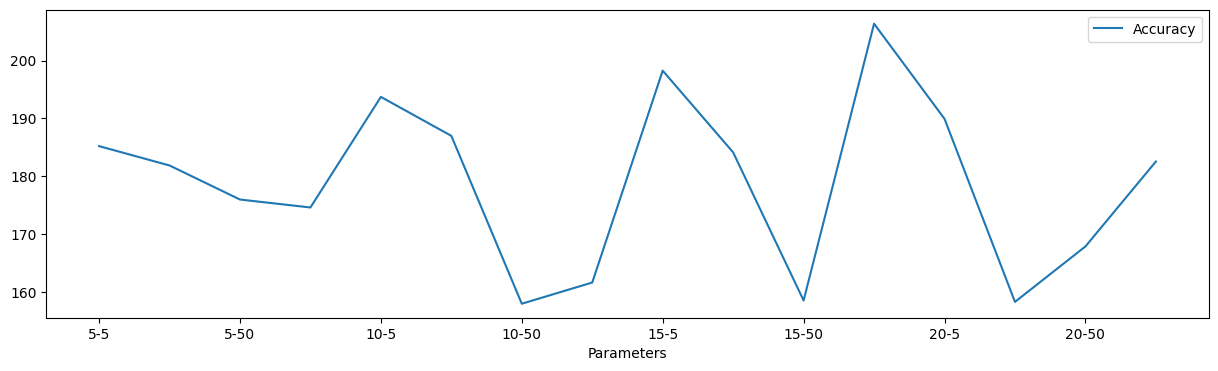

In [ ]:
ResultsData.plot(x='Parameters', y='Accuracy', figsize=(15,4), kind='line')

### Training the ANN Model with Best Parameters

In [ ]:
# Fitting the ANN to the Training set
model.fit(X_train, y_train, batch_size = 15, epochs = 50, verbose=0)

# Generating Predictions on testing data
Predictions=model.predict(X_test)

# Scaling the predicted Price data back to original price scale
Predictions=TargetVarScalerFit.inverse_transform(Predictions)

# Scaling the y_test Price data back to original price scale
y_test_orig=TargetVarScalerFit.inverse_transform(y_test)

# Scaling the test data back to original scale
Test_Data=PredictorScalerFit.inverse_transform(X_test)

TestingData=pd.DataFrame(data=Test_Data, columns=Predictors)
TestingData['log_idps']=y_test_orig
TestingData['pred_log_idps']=Predictions
TestingData.head()

17/17 [==============================] - 0s 2ms/step


,Economics,Governance,Social,Capacity,Ecosystem,Exposure,Food,Habitat,Health,Infrastructure,Sensitivity,Magnitude,Population,Population Density (People per Sq. Km.),"Net international migrants, both sexes",log_idps,pred_log_idps
0,0.643221,0.781837,0.663970,0.280019,0.469278,0.519501,0.246007,0.528106,0.226299,0.432298,0.340670,13.171690,1.262153e+08,346.3,94438.0,5.905362,9.226275
1,0.676939,0.821446,0.599509,0.302669,0.372606,0.479702,0.362785,0.489519,0.227527,0.146413,0.160552,12.548337,2.437018e+07,3.2,241770.0,3.465736,4.909887
2,0.273172,0.349983,0.230581,0.608792,0.431001,0.492328,0.519134,0.590062,0.426909,0.413496,0.340419,10.991955,9.054215e+07,303.7,-246329.0,9.879707,9.088201
3,0.594974,0.472279,0.580677,0.439379,0.515650,0.448469,0.391348,0.433590,0.373881,0.205598,0.266851,15.775487,1.404032e+09,150.5,0.0,13.576804,9.105621
4,0.618120,0.750582,0.647906,0.242141,0.423670,0.481034,0.348389,0.449201,0.174245,0.162246,0.204079,13.204771,3.268382e+08,35.7,651793.0,5.342334,5.216302


### Model Accuracy

In [ ]:
# Computing the absolute percent error
APE=100*(abs(TestingData['log_idps']-TestingData['pred_log_idps'])/TestingData['log_idps'])
TestingData['APE']=APE

print('The absolute percent error of ANN model is:', 100-np.mean(APE))
TestingData.head()

The absolute percent error of ANN model is: 34.64612805466324


,Economics,Governance,Social,Capacity,Ecosystem,Exposure,Food,Habitat,Health,Infrastructure,Sensitivity,Magnitude,Population,Population Density (People per Sq. Km.),"Net international migrants, both sexes",log_idps,pred_log_idps,APE
0,0.643221,0.781837,0.663970,0.280019,0.469278,0.519501,0.246007,0.528106,0.226299,0.432298,0.340670,13.171690,1.262153e+08,346.3,94438.0,5.905362,9.226275,56.235565
1,0.676939,0.821446,0.599509,0.302669,0.372606,0.479702,0.362785,0.489519,0.227527,0.146413,0.160552,12.548337,2.437018e+07,3.2,241770.0,3.465736,4.909887,41.669388
2,0.273172,0.349983,0.230581,0.608792,0.431001,0.492328,0.519134,0.590062,0.426909,0.413496,0.340419,10.991955,9.054215e+07,303.7,-246329.0,9.879707,9.088201,8.011437
3,0.594974,0.472279,0.580677,0.439379,0.515650,0.448469,0.391348,0.433590,0.373881,0.205598,0.266851,15.775487,1.404032e+09,150.5,0.0,13.576804,9.105621,32.932513
4,0.618120,0.750582,0.647906,0.242141,0.423670,0.481034,0.348389,0.449201,0.174245,0.162246,0.204079,13.204771,3.268382e+08,35.7,651793.0,5.342334,5.216302,2.359116


In [ ]:
from sklearn.metrics import mean_squared_error, r2_score
rmse_nn = mean_squared_error(np.exp(TestingData['log_idps']), np.exp(TestingData['pred_log_idps']))**0.5
rmse_nn

167648.6789415335

In [ ]:
abs_diff_rf = np.abs(np.exp(TestingData['log_idps']) - np.exp(TestingData['pred_log_idps']))

# Finding out the percentage of predictions within 5000 IDP counts of the actual value
percentage_within_5000_rf = np.mean(abs_diff_rf <= 3000) * 100

percentage_within_5000_rf

64.95238095238095